In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [6]:
train_dataset = torchvision.datasets.MNIST('./', train=True, download=True)
test_dataset = torchvision.datasets.MNIST('./', train=False, download=True)

텐서 값, Nomalization으로 변환 진행

In [8]:
transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])

train_dataset = torchvision.datasets.MNIST('./', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('./', train=False, download=True, transform=transform)

In [9]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [10]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

### 1-2. Display Sample Data
Dataset 클래스는 인덱싱이 가능하다.

인덱싱을 통해 하나의 data를 확인해보면, (이미지, 라벨)의 튜플이다.

이미지 크기는 (28, 28) 이다

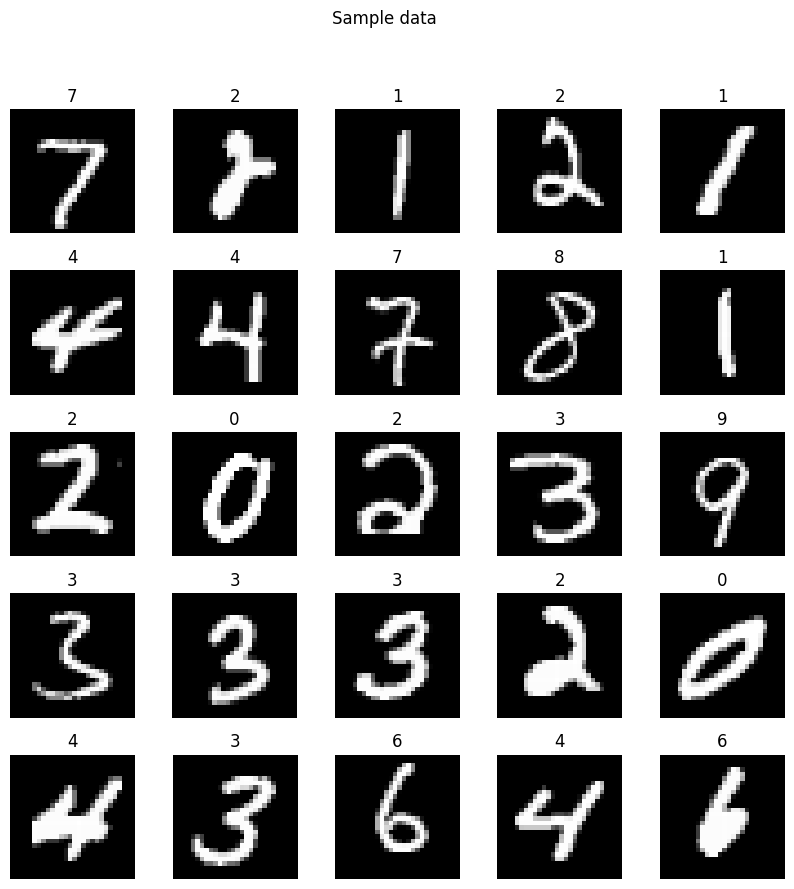

In [12]:
row = 5
col = 5
plt.figure(figsize=(10,10))
for i in range(1, row*col + 1) :
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    # tensor to numpy
    img = img.numpy().reshape(28, 28, -1)
    plt.subplot(row, col, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(label)
plt.suptitle('Sample data')
plt.subplots_adjust(wspace=0.3, hspace=0.3)  # 서브플롯 간의 여백을 조금 더 넓게 설정
plt.show()

In [13]:
img, label = train_dataset[sample_idx]
print(img.shape)
print(type(label))

torch.Size([1, 28, 28])
<class 'int'>


In [14]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [15]:
train_loader

In [16]:
test_loader

## 2. Model Definition
Pytorch의 nn.Module은 모든 neural network의 base class이다.
init 함수에서 super()를 호출하여 base class의 변수들을 상속받는다.

### 2-1 Neural Network Definition

In [19]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1) # mnist는 흑백이므로 1채널
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(6272, 128) # pooling을 통해 (32, 28, 28) 크기의 이미지를 (32, 14, 14)로 줄임. 풀링이 있었다고 가정한 계산
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        # (1, 28, 28) -> (16, 28, 28)
        x = self.conv1(x)
        x = F.relu(x)
        
        # (16, 28, 28) -> (32, 28, 28)
        x = self.conv2(x)
        x = F.relu(x)
        
        # (32, 28, 28) -> (32, 14, 14)
        x = F.max_pool2d(x, 2)

        # (32, 14, 14) -> (6272, 1)
        x = torch.flatten(x, 1)

        # (6272, 1) -> (128, 1)
        x = self.fc1(x)
        x = F.relu(x)
        
        # (128, 1) -> (10, 1)
        x = self.fc2(x)
        
        output = F.log_softmax(x, dim=1)
        return output

### 2-2 Train

In [21]:
def train(model, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # output: [64, 10] tensor with gradient information ex) grad_fn=<LogSoftmaxBackward0>
        output = model(data)    
        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0 :
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

### 2-3 Test

In [23]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

 ### 모델이 잘못 예측한 샘플을 시각화. 틀린 예측을 찾아, 시각적으로 확인하고, 모델 개선

In [56]:
def visualize_wrong_sample(model, test_loader):
    with torch.no_grad():
        sample_batch = next(iter(test_loader))
        img_batch, label_batch = sample_batch # 하나의 샘플 배치에서 데이터를 가져옴 
        # output_prob: [64, 10]
        # output_pred: [64, 1]
        output_prob = model(img_batch)
        output_pred = torch.argmax(output_prob, dim=1)

    ##### Plot #####
    row, col = 3, 2
    cnt = 1
    for i in range(len(img_batch)):
        if label_batch[i] == output_pred[i]: # continue는 모델이 맞춘 예측은 건너뛰고, 틀린 예측만 시각화.
            continue
        
        img = img_batch[i].numpy().reshape(28, 28, -1)
        ans, pred = label_batch[i].item(), output_pred[i].item()
        plt.subplot(row, col, cnt)
        cnt += 1
        plt.imshow(img, cmap='gray')
        plt.title('Ans: ' + str(ans) + ', Prediction: ' + str(pred))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.suptitle('Visualize Wrong Samples')
    plt.show()
    
#visualize_wrong_sample(myNeuralNet, test_loader)

## 3.Script


In [58]:
myNeuralNet = NeuralNet()
myOptimizer = torch.optim.Adam(myNeuralNet.parameters())

epochs = 3
for epoch in range(epochs):
    train(myNeuralNet, train_loader, myOptimizer, epoch, log_interval=40)
test(myNeuralNet, test_loader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.316717
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.405026
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.308446
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.199847
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.156286
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.080918
Train Epoch: 0 [15360/60000 (26%)]	Loss: 0.065842
Train Epoch: 0 [17920/60000 (30%)]	Loss: 0.149327
Train Epoch: 0 [20480/60000 (34%)]	Loss: 0.055542
Train Epoch: 0 [23040/60000 (38%)]	Loss: 0.122349
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.136827
Train Epoch: 0 [28160/60000 (47%)]	Loss: 0.107805
Train Epoch: 0 [30720/60000 (51%)]	Loss: 0.066098
Train Epoch: 0 [33280/60000 (55%)]	Loss: 0.013315
Train Epoch: 0 [35840/60000 (60%)]	Loss: 0.046028
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.018142
Train Epoch: 0 [40960/60000 (68%)]	Loss: 0.019986
Train Epoch: 0 [43520/60000 (72%)]	Loss: 0.262110
Train Epoch: 0 [46080/60000 (77%)]	Loss: 0.015955
Train Epoch: 0 [48640/60000 (81%)]	Loss: 0.102107
Train Epoc

In [62]:
visualize_wrong_sample(myNeuralNet, test_loader)

<Figure size 640x480 with 0 Axes>

In [28]:
# 모델의 state_dict 출력
print("Model's state_dict:")
for param_tensor in myNeuralNet.state_dict():
    print(param_tensor, "\t", myNeuralNet.state_dict()[param_tensor].size())
    #print(myNeuralNet.state_dict()[param_tensor])

Model's state_dict:
conv1.weight 	 torch.Size([16, 1, 3, 3])
conv1.bias 	 torch.Size([16])
conv2.weight 	 torch.Size([32, 16, 3, 3])
conv2.bias 	 torch.Size([32])
fc1.weight 	 torch.Size([128, 6272])
fc1.bias 	 torch.Size([128])
fc2.weight 	 torch.Size([10, 128])
fc2.bias 	 torch.Size([10])


In [67]:
model_path = './CNN_MNIST_Classifier_0227'
torch.save(myNeuralNet.state_dict(), model_path)

In [61]:
myNeuralNet_loaded = NeuralNet()
myNeuralNet_loaded.load_state_dict(torch.load(model_path, weights_only=True))
myNeuralNet_loaded.eval()
test(myNeuralNet_loaded, test_loader)


Test set: Average loss: 0.0386, Accuracy: 9876/10000 (99%)

